## Feature Engineering: Housing data project
#### I don't really know what feature engineering is but this is where I am implementing my strategy and creating new collumns that are mathematically derived from 1 or more collumns describing an attribute and some measure of that attribute

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.metrics import mean_squared_error
from a02_as_funct import map_home, numeric_houses, dummy_houses, multiplier_attempt1, multiplier_attempt2, multiplier_attempt3
import seaborn as sns

### read raw data

In [2]:
houses = pd.read_csv('../datasets/train.csv')
houses.head()
houses.columns =houses.columns.str.lower().str.replace(' ','_')

y=houses['saleprice']

### Clean, map the attribute and modifier collumns when needed, ensure datatypes, ordinally encode
#### I built a series of functions that rapidly do this for data shaped like the data we are provided 

In [3]:
houses1 = map_home(houses.drop(columns=['saleprice']))

X0 = numeric_houses(houses1) # not dummified yet
X = X0.drop(columns=['pid'])
#houses3 = dummy_houses(houses2)

In [4]:
# redoing this as before for all of X
cat_features = ['mas_vnr_type','bsmt_exposure','garage_type','alley','misc_feature',
                'land_contour','ms_subclass','ms_zoning','street','neighborhood',
                'condition_2','bldg_type', 'house_style','roof_style','roof_matl',
                'exterior_1st','exterior_2nd','foundation',
                'central_air','electrical','sale_type','condition_1','utilities','lot_config','land_slope',
                'heating','paved_drive','mo_sold']
ct = ColumnTransformer([('oh', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_features)],
                       remainder='passthrough')
X_trans= ct.fit_transform(X)
X_dummy =pd.DataFrame(X_trans,columns=ct.get_feature_names_out())

In [5]:
# this is not related to the standard scale process for training data/eda
"""X_multiplied = multiplier_attempt3(X_dummy)
sc1 = StandardScaler()
X_multiplied_sc=sc1.fit_transform(X_multiplied)"""

'X_multiplied = multiplier_attempt3(X_dummy)\nsc1 = StandardScaler()\nX_multiplied_sc=sc1.fit_transform(X_multiplied)'

In [6]:
# Already 1-hot-encoded time to math
X_train,X_test,y_train,y_test = train_test_split(X_dummy,y,random_state=512)


In [7]:
X_train.shape

(1538, 230)

In [8]:
X_dummy.shape

(2051, 230)

### Now I need to mathematically combine the collumns I mapped out at the start of this 

In [9]:
X_train_multiplied = multiplier_attempt3(X_train)
X_test_multiplied = multiplier_attempt3(X_test)

In [10]:
## standard scale
sc = StandardScaler()
X_train_multiplied_sc=sc.fit_transform(X_train_multiplied)
X_test_multiplied_sc=sc.transform(X_test_multiplied)

## Building a linear model. does very well on the test data with an r2 score of 95%. Does poorly on test data - 54% the model is overfit

## KnRegression n_neighbors optimization using GridSearchCV
#### heavily influenced by lesson 406 at GA-DSI

In [11]:
# pgrid= {'n_neighbors':np.arange(2,100)}

In [12]:
#knn = KNeighborsRegressor()

In [13]:
# gs= GridSearchCV(estimator=knn,param_grid=pgrid)


In [14]:
#%%time
#gs.fit(X_train_multiplied_sc,y_train)

In [15]:
#gs.score(X_train_multiplied_sc,y_train)

In [16]:
#gs.score(X_test_multiplied_sc,y_test)

In [17]:
#X_test_multiplied_sc.shape

In [18]:
#gs.best_estimator_

## Before changes to the mathematical operations i have found 12 is the best k value now processes the entire training dataset, afterwards 4 seems optimal

## time to deal with confounding variables: parsimony please

In [19]:
numeric_cols= list(X.corr(numeric_only=True).columns)

In [20]:
pd.DataFrame(data=np.where(np.abs(X.corr(numeric_only=True))>.85,1,0),index = numeric_cols,columns=numeric_cols ).sum()

ms_subclass        1
lot_frontage       1
lot_area           1
overall_qual       1
overall_cond       1
year_built         1
year_remod/add     1
mas_vnr_area       1
exter_qual         1
exter_cond         1
bsmt_qual          1
bsmt_cond          1
bsmtfin_type_1     1
bsmtfin_sf_1       1
bsmtfin_type_2     1
bsmtfin_sf_2       1
bsmt_unf_sf        1
total_bsmt_sf      1
heating_qc         1
1st_flr_sf         1
2nd_flr_sf         1
low_qual_fin_sf    1
gr_liv_area        1
bsmt_full_bath     1
bsmt_half_bath     1
full_bath          1
half_bath          1
bedroom_abvgr      1
kitchen_abvgr      1
kitchen_qual       1
totrms_abvgrd      1
functional         1
fireplaces         2
fireplace_qu       2
garage_yr_blt      3
garage_finish      1
garage_cars        2
garage_area        2
garage_qual        3
garage_cond        3
wood_deck_sf       1
open_porch_sf      1
enclosed_porch     1
3ssn_porch         1
screen_porch       1
pool_area          2
pool_qc            2
misc_val     

## A few of these have high correlations (over 90%) with other X variables
#### maybe when I calculate my new columns I can deal with a few of these and adjust
```
pool_area          2
pool_qc            2
garage_yr_blt      3
```
#### I adjusted my ordinal encoding formulas which minimally lowered my kaggle score. I think theres too much noise so I also now remove columns highly correlated or that do nothing but modify the value of other features

## A few of these have high correlations (over 85%) with other X variables
pool_area          2
pool_qc            2
garage_cars        2
garage_area        2
garage_qual        3
garage_cond        3
fireplaces         2
fireplace_qu       2
garage_yr_blt      3

In [21]:
#knn.score(X_multiplied_sc,y)# knregressor is trained and process is repeated for all data (hopefully) without leakage

In [22]:
#knn.score(X_multiplied_sc,y)

In [23]:
test = pd.read_csv('../datasets/test.csv')
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [24]:
test1 = map_home(test)

X_kaggle = numeric_houses(test1) # not dummified yet

#ct.get_feature_names_out()
#X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=512)
# Similiar to a technique shared by Katie Ellsweig over Zoom chat in GA-DSI911
"""cat_features = ['mas_vnr_type','bsmt_exposure','garage_type','alley','misc_feature',
                'land_contour','ms_subclass','ms_zoning','street','neighborhood',
                'condition_2','bldg_type', 'house_style','roof_style','roof_matl',
                'exterior_1st','exterior_2nd','foundation',
               'central_air','electrical','sale_type','condition_1','utilities','lot_config','land_slope',
               'heating','paved_drive']
ct = ColumnTransformer([('oh', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_features)
], remainder='passthrough')"""
X_kaggle_dummy = pd.DataFrame(ct.transform(X_kaggle),columns=ct.get_feature_names_out())
#X_test_dummy = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())
X_kaggle_multiplied = multiplier_attempt3(X_kaggle_dummy)
#X_test_multiplied = multiplier_attempt3(X_test_dummy)
## standard scale
#sc = StandardScaler()
X_kaggle_multiplied_sc=sc.transform(X_kaggle_multiplied)
#X_test_multiplied_sc=sc.transform(X_test_multiplied)

C:\Users\seanh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0, 14, 15, 16, 19, 20, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [25]:
X_kaggle_multiplied_sc.shape

(878, 240)

## Skipping over to generate results using Ridge regression

In [26]:
#y_pred = knn.predict(X_kaggle_multiplied_sc)

In [27]:
"""data={'Id': test.id , 'SalePrice': y_pred}

df = pd.DataFrame(data)

df.to_csv('../datasets/kaggle_sub_5.csv', index=False)

#df = pd.read_csv('../datasets/kaggle_sub_3.csv')
df.head()"""

"data={'Id': test.id , 'SalePrice': y_pred}\n\ndf = pd.DataFrame(data)\n\ndf.to_csv('../datasets/kaggle_sub_5.csv', index=False)\n\n#df = pd.read_csv('../datasets/kaggle_sub_3.csv')\ndf.head()"

In [28]:
X_multiplied = multiplier_attempt3(X_dummy)
X_multiplied_sc=sc.fit_transform(X_multiplied)

In [29]:
r_alphas = np.logspace(2,3,1000)
ridgecv = RidgeCV(alphas=r_alphas, cv=15)

In [30]:
X_train_multiplied.shape

(1538, 240)

In [31]:
X_multiplied_sc.shape

(2051, 240)

In [32]:
X_kaggle_multiplied_sc.shape

(878, 240)

In [33]:
%%time
ridgecv.fit(X_multiplied_sc,y)

CPU times: total: 5min 14s
Wall time: 1min 49s


RidgeCV(alphas=array([ 100.        ,  100.23075483,  100.46204213,  100.69386315,
        100.9262191 ,  101.15911122,  101.39254076,  101.62650894,
        101.86101702,  102.09606623,  102.33165783,  102.56779307,
        102.80447321,  103.0416995 ,  103.27947319,  103.51779556,
        103.75666787,  103.9960914 ,  104.2360674 ,  104.47659716,
        104.71768195,  104.95932306,  105.20152176,  105.44427935,
        105.68759712,  105.93147635,  10...
        939.6648315 ,  941.83315346,  944.00647894,  946.18481947,
        948.36818663,  950.55659201,  952.75004724,  954.94856398,
        957.1521539 ,  959.36082871,  961.57460014,  963.79347996,
        966.01747995,  968.24661193,  970.48088774,  972.72031925,
        974.96491835,  977.21469697,  979.46966707,  981.72984062,
        983.99522963,  986.26584613,  988.54170219,  990.8228099 ,
        993.10918137,  995.40082876,  997.69776424, 1000.        ]),
        cv=15)

In [34]:
ridgecv.score(X_multiplied_sc,y)

0.9039270739521669

In [35]:
y_pred = ridgecv.predict(X_kaggle_multiplied_sc)

In [36]:
y_pred_all = ridgecv.predict(X_multiplied_sc)

In [37]:
mean_squared_error(y,y_pred_all,squared=False)

24560.73342243931

In [38]:
ridgecv.alpha_

724.2022334607316

In [39]:
# 9 is technically ready, I got a better alphpa

In [40]:
type(y_pred)

numpy.ndarray

In [41]:
data={'Id': test.id , 'SalePrice': y_pred}

df = pd.DataFrame(data)

df.to_csv('../datasets/kaggle_sub_11_ridge.csv', index=False)

#df = pd.read_csv('../datasets/kaggle_sub_3.csv')
df.head()

,Id,SalePrice
0,2658,119513.847677
1,2718,170033.170288
2,2414,221609.938940
3,1989,110464.943799
4,625,190474.578022


In [42]:
y_preds = ridgecv.predict(X_multiplied_sc)
diff = y_preds-y 

''

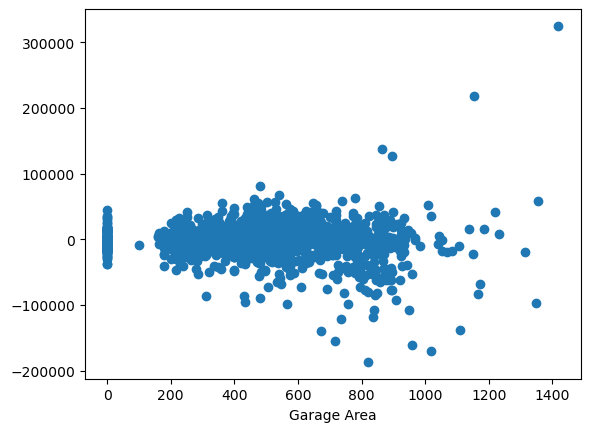

In [43]:
plt.scatter(X.garage_area,diff)
plt.xlabel('Garage Area')
#not helpful for the customer but shows the residuals are well distributed considering the data
;

In [44]:
X['ms_subclass']=np.where(X['ms_subclass']== 20, 'four_zero',X['ms_subclass'])

In [45]:
X['ms_subclass']

0              60
1              60
2       four_zero
3              60
4              50
          ...    
2046    four_zero
2047           30
2048           50
2049    four_zero
2050           60
Name: ms_subclass, Length: 2051, dtype: object

In [46]:
#X['ms_subclass'] = np.where(X['ms_subclass'].str.is_digit(),X['ms_subclass'].astype(str),X['ms_subclass'].astype(str))

In [47]:
hard_coded_bool_columns=[X['ms_subclass']=='four_zero',X['garage_area']>=2*np.mean(X['garage_area'])] # twice the average garage size for this type of house

In [48]:
mask1 =hard_coded_bool_columns[0]
mask2 =hard_coded_bool_columns[1]
X0.loc[mask1].loc[mask2]

,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,land_contour,utilities,lot_config,...,screen_porch,pool_area,pool_qc,misc_feature,misc_val,mo_sold,yr_sold,sale_type,fence_private,fence_wood
81,527214050,20,RL,63.0,17423,Pave,NaN,Lvl,AllPub,CulDSac,...,0,0,0,NaN,0,7,2009,New,0,0
199,528166060,20,RL,103.0,13472,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,6,2009,WD,0,0
526,528114010,20,RL,120.0,14780,Pave,NaN,HLS,AllPub,Corner,...,156,0,0,NaN,0,6,2006,WD,0,0
623,528176030,20,RL,100.0,14836,Pave,NaN,HLS,AllPub,Inside,...,0,0,0,NaN,0,2,2009,WD,0,0
682,528104050,20,RL,114.0,14803,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,6,2008,New,0,0
800,528118050,20,RL,59.0,17169,Pave,NaN,Lvl,AllPub,CulDSac,...,0,0,0,NaN,0,8,2007,New,0,0
1060,906340100,20,RL,84.0,10933,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,7,2009,New,0,0
1158,906412010,20,RL,91.0,11778,Pave,NaN,Lvl,AllPub,Inside,...,255,0,0,NaN,0,6,2008,WD,0,0
1187,528435060,20,RL,83.0,9849,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,6,2007,New,0,0
1227,528176010,20,RL,110.0,14300,Pave,NaN,HLS,AllPub,Inside,...,0,0,0,NaN,0,6,2010,WD,0,0


In [49]:
def how_much_a_deal(X0,X_multiplied,X_multiplied_sc,y,hard_coded_bool_columns,ridgecv): # i'm tired, don't judge too harshly but this is all for the narrative in the presentation
    y_preds = ridgecv.predict(X_multiplied_sc)
    X0['payed_vs_calc'] = y_preds-y 
    # this takes imagining the given y values are historic sale prices. 
    mask1 =hard_coded_bool_columns[0]
    mask2 =hard_coded_bool_columns[1]
    return X0.loc[mask1].loc[mask2][['pid','payed_vs_calc']].sort_values('payed_vs_calc')


In [50]:
towards_buyer_df= how_much_a_deal(X0,X_multiplied,X_multiplied_sc,y,hard_coded_bool_columns,ridgecv)

In [51]:
towards_buyer_df # here are parcels of land that fit your specifications ordered by the difference in municipal records and the calculated worth
# 'payed_vs_calc' is how much over you are expecting the value of a house to be
# my RMSE is around 30 k at the moment so my recomendation is PID:528104050 or PID:908154195

,pid,payed_vs_calc
1964,527216080,-137857.396215
623,528176030,-107997.395195
1158,906412010,-96597.588320
81,527214050,-83479.967690
800,528118050,-68221.748026
1227,528176010,-52521.803569
526,528114010,-18031.550894
1875,923202220,-6615.290329
199,528166060,2777.483803
1557,907250070,7694.132996


In [52]:
towards_buyer_df.to_csv('../datasets/deliverable.csv')

### Takeaways from these notebooks. 
This was excelent work for me and I feel much more advanced for having complete it
I need sleep
the model mathematics portion of this project that was the most disaopainted in terms of the ratio effort given vs imporement in the model.

## Customer Deliveralbes:

* Can search for houses with certain specs in existing dataframes
* Can rate reach sorted house in terms of the difference between model predicted value and municipal records to capitalize on opportunity.
* The ridge regression model created and cross validated results in a R2 score of 90%: 90% of the variation of * the sale price can be explained by our model. it also has a 24K RMSE (assuming there may be leakage I need to check) which will help the customer have more options for their constraints
